In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import csv

# Jupyter Notebookでグラフをインライン表示するためのマジックコマンド
%matplotlib inline

# グラフのスタイルを少しきれいにします (お好みで)
plt.style.use('ggplot')

print("ライブラリのインポート完了。")

ライブラリのインポート完了。


## --- グローバル設定 ---


In [15]:
# --- グローバル設定 ---

# 保存先フォルダ名
OUTPUT_DIR = 'output'

# モニターコンデンサの容量 [F]
C_m_Farad = 3300E-12    # 3300[pF]

# 波形の周波数 [Hz] 電源の周波数
f_Hz = 9000.0

# ★★★ 追加 ★★★
# デバイスの長さ [m] (W/m の計算用)
# 9.81 cm = 0.0981 m
device_length_meters = 0.0981

#保存先
FILENAME_TEMPLATE = 'testdata/ALL{caseNum:04d}.CSV' 

#Headerは飛ばして数値が始まる場所
skipRowNum = 25

# --- フォルダ作成 ---
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)
    print(f"フォルダ '{OUTPUT_DIR}' を作成しました。")

## --- 解析ロジックの関数定義 ---


### CSVファイルからメタデータと電圧データを読み込む関数


In [5]:
def load_data_and_metadata(filename):
    """
    CSVファイルからメタデータと電圧データを読み込む関数 (修正版)
    """
    print(f"--- ファイル読み込み開始: {filename} ---")
    
    # 1. メタデータの自動抽出
    metadata = {}
    keys_to_extract = ['Memory Length', 'Sampling Period', 'Trigger Address', 'Horizontal Scale']
    
    try:
        with open(filename, 'r', encoding='utf-8') as f:
            reader = csv.reader(f)
            for i, row in enumerate(reader):
                if i >= skipRowNum: break
                if not row: continue
                
                key = row[0]
                if key in keys_to_extract and key not in metadata:
                    metadata[key] = row[1]
        
        # 必要なキーが揃っているかチェック
        for key in keys_to_extract:
            if key not in metadata:
                # 必要なキーが見つからなかった場合、KeyErrorを発生させる
                raise KeyError(f"必要なキー '{key}' がヘッダーに見つかりません。")

        # 2. メタデータの型変換
        meta_typed = {
            'MEMORY_LENGTH': int(metadata['Memory Length']),
            'SAMPLING_PERIOD': float(metadata['Sampling Period']),
            'TRIGGER_ADDRESS': int(metadata['Trigger Address']),
            'HORIZONTAL_SCALE': float(metadata['Horizontal Scale'])
        }
        print("メタデータの抽出成功:")
        for key, val in meta_typed.items():
            print(f"  {key}: {val}")

    except FileNotFoundError:
        print(f"エラー: ファイル {filename} が見つかりません。")
        return None, None, None # ★修正1: 戻り値を3つに
    except Exception as e:
        print(f"メタデータ抽出エラー: {e}")
        return None, None, None # ★修正1: 戻り値を3つに

    # 3. データ本体の読み込み
    df = pd.read_csv(
        filename,
        skiprows=skipRowNum, # ★修正2: 波括弧 {} を削除
        header=None,
        usecols=[1, 3], #時間の値は必要ないので排除
        names=['CH1_VOLTAGE', 'CH2_VOLTAGE']
    )
    ch1_v = df['CH1_VOLTAGE'].to_numpy()
    ch2_v = df['CH2_VOLTAGE'].to_numpy()
    
    print(f"データ読み込み完了 (サンプル数: {len(ch1_v)})")
    return meta_typed, ch1_v, ch2_v

### メタデータから時間軸 (ms) を計算する関数


In [6]:

def calculate_time_axis(metadata):
    Sample_Index = np.arange(metadata['MEMORY_LENGTH'])
    Time = (Sample_Index - metadata['TRIGGER_ADDRESS']) * metadata['SAMPLING_PERIOD']
    Time_ms = Time * 1000
    print(f"時間軸を生成しました: {Time_ms.min():.2f} ms ～ {Time_ms.max():.2f} ms")
    return Time_ms


###  全体波形とズーム波形をプロットし保存する関数


In [7]:
def plot_waveforms(Time_ms, CH1_VOLTAGE, CH2_VOLTAGE, HORIZONTAL_SCALE, caseNum, base_output_dir):

    # --- ケース別サブフォルダのパスを決定し、作成 ---
    case_dir = os.path.join(base_output_dir, f'Case_{caseNum}')
    os.makedirs(case_dir, exist_ok=True) # フォルダが既にあってもエラーにしない

    # --- 4. 【プロット1】全体波形 ---
    fig, ax1 = plt.subplots(figsize=(12, 6))
    ax1.plot(Time_ms, CH1_VOLTAGE, color='b', label='CH1 Voltage (HV 1000x)', alpha=0.9)
    ax1.set_xlabel('Time [ms]'); ax1.set_ylabel('CH1 Voltage [V]', color='b')
    ax1.tick_params(axis='y', labelcolor='b'); ax1.grid(True, linestyle='--', alpha=0.6)
    ax2 = ax1.twinx()
    ax2.plot(Time_ms, CH2_VOLTAGE, color='r', label='CH2 Voltage (Diff 1x)', alpha=0.9)
    ax2.set_ylabel('CH2 Voltage [V]', color='r'); ax2.tick_params(axis='y', labelcolor='r')
    ax1.axvline(x=0, color='k', linestyle=':', linewidth=2, label='Trigger Point (t=0)')
    fig.suptitle(f'Waveform (Full Range) - Case {caseNum}', fontsize=16)
    lines, labels = ax1.get_legend_handles_labels(); lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines + lines2, labels + labels2, loc='upper right'); plt.tight_layout()
    
    # サブフォルダに保存
    save_path_full = os.path.join(case_dir, f"Waveform_Full_Case_{caseNum}.png")
    plt.savefig(save_path_full); plt.show()

    # --- 5. 【プロット2】ズーム波形 ---
    zoom_range_ms = 5 * HORIZONTAL_SCALE * 1000
    fig_zoom, ax_zoom = plt.subplots(figsize=(12, 6))
    ax_zoom.plot(Time_ms, CH1_VOLTAGE, color='b', label='CH1 Voltage (HV 1000x)')
    ax_zoom2 = ax_zoom.twinx()
    ax_zoom2.plot(Time_ms, CH2_VOLTAGE, color='r', label='CH2 Voltage (Diff 1x)')
    ax_zoom.axvline(x=0, color='k', linestyle=':', linewidth=2, label='Trigger Point (t=0)')
    ax_zoom.set_xlim(-zoom_range_ms, zoom_range_ms)
    ax_zoom.set_xlabel('Time [ms]'); ax_zoom.set_ylabel('CH1 Voltage [V]', color='b')
    ax_zoom2.set_ylabel('CH2 Voltage [V]', color='r'); ax_zoom.tick_params(axis='y', labelcolor='b')
    ax_zoom2.tick_params(axis='y', labelcolor='r'); fig_zoom.suptitle(f'Waveform Zoom (±{zoom_range_ms:.2f} ms) - Case {caseNum}', fontsize=16)
    lines, labels = ax_zoom.get_legend_handles_labels(); lines2, labels2 = ax_zoom2.get_legend_handles_labels()
    ax_zoom.legend(lines + lines2, labels + labels2, loc='upper right'); ax_zoom.grid(True, linestyle=':', alpha=0.7)
    plt.tight_layout()
    
    # サブフォルダに保存
    save_path_zoom = os.path.join(case_dir, f"Waveform_Zoom_Case_{caseNum}.png")
    plt.savefig(save_path_zoom); plt.show()
    print(f"波形プロットを {case_dir} に保存しました。")

###  DCオフセットを除去する関数


In [8]:

def calculate_ac_components(CH1_VOLTAGE, CH2_VOLTAGE):
    CH1_AC = CH1_VOLTAGE - np.mean(CH1_VOLTAGE)
    CH2_AC = CH2_VOLTAGE - np.mean(CH2_VOLTAGE)
    print("DCオフセットを除去しました。")
    return CH1_AC, CH2_AC


###     リサージュグラフを描画・保存する関数


In [9]:
def plot_and_save_lissajous(CH1_AC, CH2_AC, caseNum, base_output_dir):
    # --- ケース別サブフォルダのパスを決定し、作成 ---
    case_dir = os.path.join(base_output_dir, f'Case_{caseNum}')
    os.makedirs(case_dir, exist_ok=True) # フォルダが既にあってもエラーにしない
    
    fig_qv, ax_qv = plt.subplots(figsize=(8, 7))
    ax_qv.plot(CH1_AC, CH2_AC, color='navy', linewidth=0.5)
    title_str = f'Lissajous Figure (Q-V Curve) - Case {caseNum}'
    ax_qv.set_title(title_str, fontsize=16)
    ax_qv.set_xlabel('CH1 Voltage (V) [Offset Removed]'); ax_qv.set_ylabel('CH2 Voltage (Q) [Offset Removed]')
    ax_qv.grid(True, linestyle=':', alpha=0.7); ax_qv.axhline(0, color='k', linestyle='--', linewidth=0.5)
    ax_qv.axvline(0, color='k', linestyle='--', linewidth=0.5); plt.tight_layout()
    
    # サブフォルダに保存
    save_path = os.path.join(case_dir, f"Lissajous_Case_{caseNum}.png")
    plt.savefig(save_path, dpi=150)
    print(f"リサージュグラフを {save_path} に保存しました。")
    plt.show()

### リサージュ面積と消費電力を計算する関数


In [10]:
def calculate_power(CH1_AC, CH2_AC, C_m_Farad, f_Hz, caseNum):
    # 面積計算 (Shoelace Formula)
    term1 = np.sum(CH1_AC * np.roll(CH2_AC, -1))
    term2 = np.sum(CH2_AC * np.roll(CH1_AC, -1))
    Area_VV = 0.5 * np.abs(term1 - term2)

    # エネルギーと電力の計算
    Energy_per_cycle_J = Area_VV * C_m_Farad
    Power_Watt = Energy_per_cycle_J * f_Hz

    print(f"\n--- [Case {caseNum}] 消費電力の計算結果 ---")
    print(f"リサージュ図形の面積 (Area_VV): {Area_VV:.2f} [V*V]")
    print(f"モニターコンデンサ容量 (C_m): {C_m_Farad:.2e} [F]")
    print(f"波形周波数 (f): {f_Hz:.1f} [Hz]")
    print(f"----------------------------------------")
    print(f"1サイクルあたりのエネルギー損失 (E): {Energy_per_cycle_J:.2e} [J/cycle]")
    print(f"平均消費電力 (P): {Power_Watt:.4f} [W]")
    
    return Power_Watt, Area_VV


### [未使用] 単一ケースの全解析を実行するラッパー関数(ウィジェットから呼び出される)

In [11]:
def run_single_case_analysis(caseNum, base_output_dir, C_m_Farad, f_Hz):
    print(f"=====================================")
    print(f"         STARTING ANALYSIS FOR CASE {caseNum}         ")
    print(f"=====================================")
    
    filename = FILENAME_TEMPLATE.format(caseNum=caseNum)
    metadata, CH1_V, CH2_V = load_data_and_metadata(filename)

    if metadata:
        # 2. 時間軸の計算
        Time_ms = calculate_time_axis(metadata)
        
        # 3. 波形プロット
        plot_waveforms(Time_ms, CH1_V, CH2_V, metadata['HORIZONTAL_SCALE'], caseNum, base_output_dir)
        
        # 4. DCオフセット除去
        CH1_AC, CH2_AC = calculate_ac_components(CH1_V, CH2_V)
        
        # 5. リサージュグラフの描画と保存
        plot_and_save_lissajous(CH1_AC, CH2_AC, caseNum, base_output_dir)
        
        # 6. 消費電力の計算
        Power, Area = calculate_power(CH1_AC, CH2_AC, C_m_Farad, f_Hz, caseNum)
        
        print(f"=====================================")
        print(f"         ANALYSIS FOR CASE {caseNum} COMPLETE        ")
        print(f"=====================================")
    else:
        print(f"Case {caseNum} の処理をスキップしました (ファイルエラー)。")

# --- メイン実行 (単一ケース) ---


--- ファイル読み込み開始: testdata/ALL0001.CSV ---
メタデータの抽出成功:
  MEMORY_LENGTH: 1000000
  SAMPLING_PERIOD: 2e-09
  TRIGGER_ADDRESS: 504999
  HORIZONTAL_SCALE: 0.0001
データ読み込み完了 (サンプル数: 1000000)
時間軸を生成しました: -1.01 ms ～ 0.99 ms


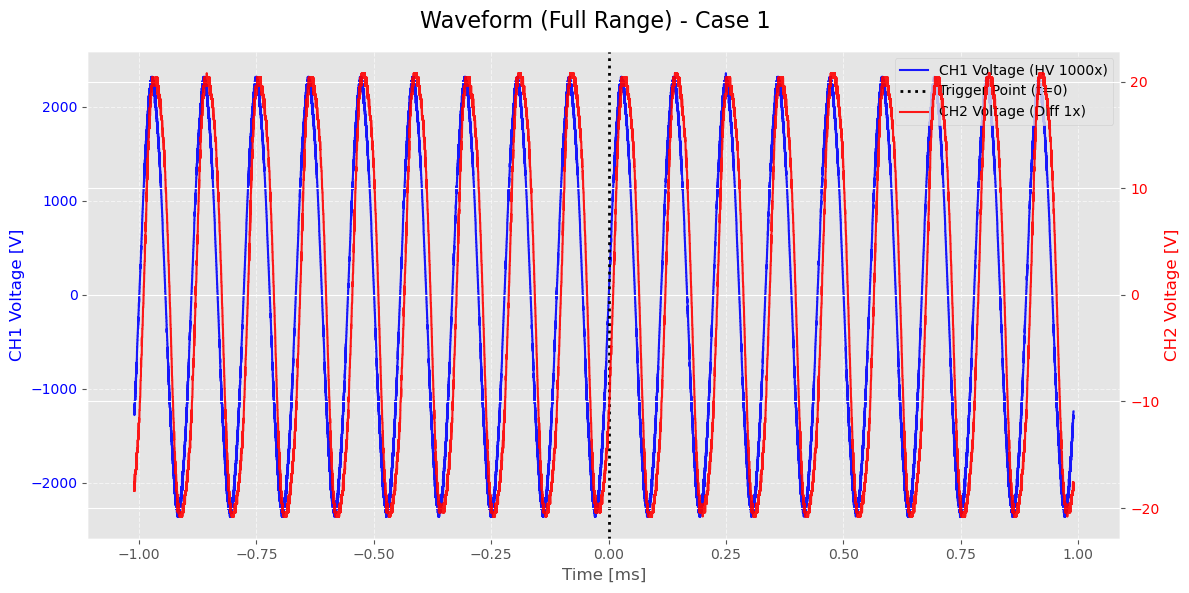

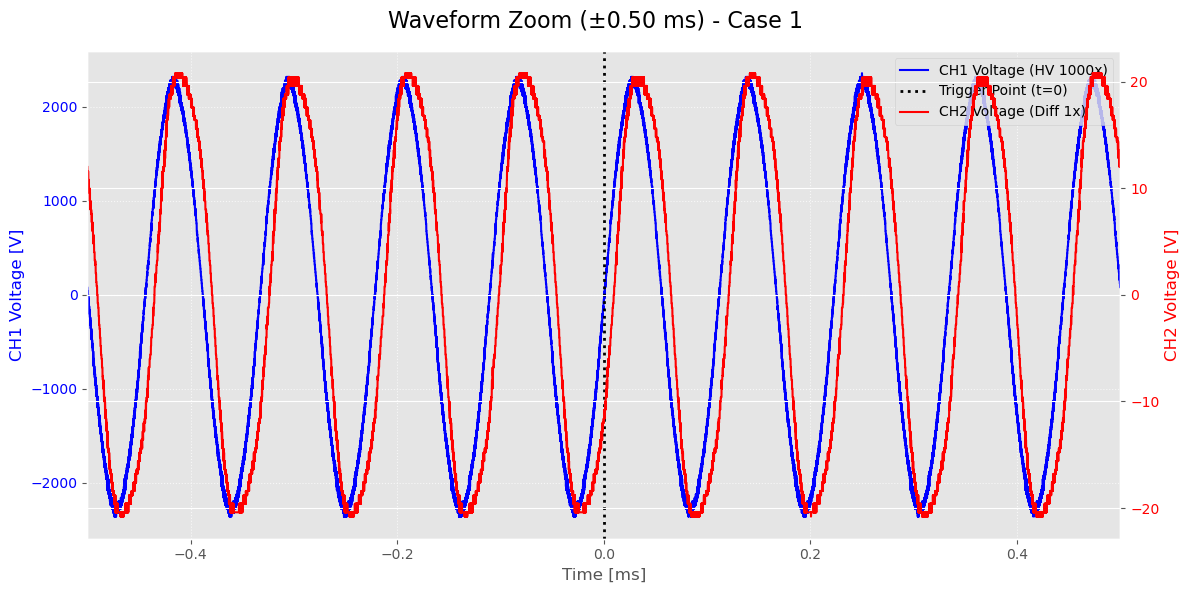

波形プロットを output/Case_1 に保存しました。
DCオフセットを除去しました。
リサージュグラフを output/Case_1/Lissajous_Case_1.png に保存しました。


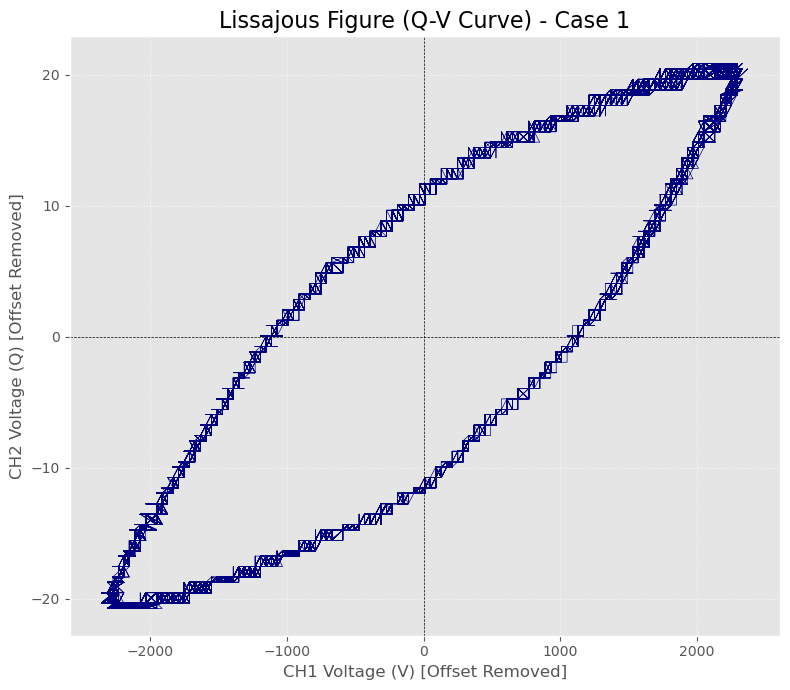


--- [Case 1] 消費電力の計算結果 ---
リサージュ図形の面積 (Area_VV): 1276768.00 [V*V]
モニターコンデンサ容量 (C_m): 3.30e-09 [F]
波形周波数 (f): 9000.0 [Hz]
----------------------------------------
1サイクルあたりのエネルギー損失 (E): 4.21e-03 [J/cycle]
平均消費電力 (P): 37.9200 [W]


In [21]:

# ★★★ 解析したいケース番号を指定 ★★★
caseNum = 1


# -----------------------------------
# 1. データの読み込み (Cell 3 の関数を呼び出し)
filename = FILENAME_TEMPLATE.format(caseNum=caseNum)
metadata, CH1_V, CH2_V = load_data_and_metadata(filename)

if metadata:
    # 2. 時間軸の計算
    Time_ms = calculate_time_axis(metadata)
    
    # 3. 波形プロット (必要なければこの行をコメントアウト)
    plot_waveforms(Time_ms, CH1_V, CH2_V, metadata['HORIZONTAL_SCALE'], caseNum, OUTPUT_DIR)
    
    # 4. DCオフセット除去
    CH1_AC, CH2_AC = calculate_ac_components(CH1_V, CH2_V)
    
    # 5. リサージュグラフの描画と保存
    plot_and_save_lissajous(CH1_AC, CH2_AC, caseNum, OUTPUT_DIR)
    
    # 6. 消費電力の計算
    Power, Area = calculate_power(CH1_AC, CH2_AC, C_m_Farad, f_Hz, caseNum)

else:
    print(f"Case {caseNum} の処理をスキップしました (ファイルエラー)。")

# --- case5-10の消費電力比較 ---


--- 全ケースのバッチ処理を開始します ---

            PROCESSING CASE 5         
--- ファイル読み込み開始: testdata/ALL0005.CSV ---
メタデータの抽出成功:
  MEMORY_LENGTH: 1000000
  SAMPLING_PERIOD: 2e-09
  TRIGGER_ADDRESS: 504999
  HORIZONTAL_SCALE: 0.0002
データ読み込み完了 (サンプル数: 1000000)
DCオフセットを除去しました。
CH1 Vpp (印加電圧): 1040.00 V
リサージュグラフを output/Case_5/Lissajous_Case_5.png に保存しました。

--- [Case 5] 消費電力の計算結果 ---
リサージュ図形の面積 (Area_VV): 29000.00 [V*V]
モニターコンデンサ容量 (C_m): 3.30e-09 [F]
波形周波数 (f): 9000.0 [Hz]
----------------------------------------
1サイクルあたりのエネルギー損失 (E): 9.57e-05 [J/cycle]
平均消費電力 (P): 0.8613 [W]
電力密度 (P/m): 8.780 [W/m] (長さ: 0.0981 m)

            PROCESSING CASE 6         
--- ファイル読み込み開始: testdata/ALL0006.CSV ---
メタデータの抽出成功:
  MEMORY_LENGTH: 1000000
  SAMPLING_PERIOD: 2e-09
  TRIGGER_ADDRESS: 504999
  HORIZONTAL_SCALE: 0.0002
データ読み込み完了 (サンプル数: 1000000)
DCオフセットを除去しました。
CH1 Vpp (印加電圧): 2120.00 V
リサージュグラフを output/Case_6/Lissajous_Case_6.png に保存しました。

--- [Case 6] 消費電力の計算結果 ---
リサージュ図形の面積 (Area_VV): 107112.00 [V*V]
モニターコンデ

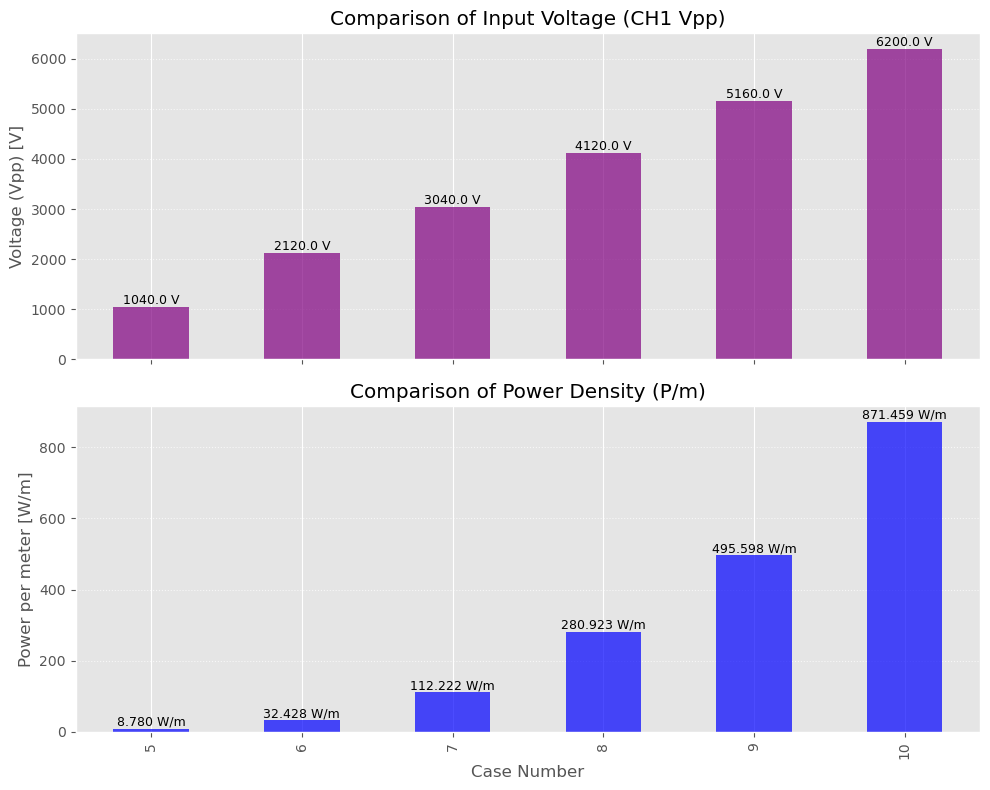

In [ ]:
# --- (将来用) 全ケースのループ実行と比較 (Vpp と Power/meter のみ) ---

print("--- 全ケースのバッチ処理を開始します ---")

# 解析結果を格納するリスト
all_results = []
# ★ ユーザー指定のケース番号
case_numbers_to_run = [5, 6, 7, 8, 9, 10] 

for num in case_numbers_to_run:
    
    print(f"\n=====================================")
    print(f"            PROCESSING CASE {num}         ")
    print(f"=====================================")
    
    filename = FILENAME_TEMPLATE.format(caseNum=num)
    metadata, CH1_V, CH2_V = load_data_and_metadata(filename)
    
    if metadata:
        # DCオフセット除去
        CH1_AC, CH2_AC = calculate_ac_components(CH1_V, CH2_V)
        
        # --- 印加電圧 (Vpp) の計算 ---
        v_pp = CH1_AC.max() - CH1_AC.min()
        print(f"CH1 Vpp (印加電圧): {v_pp:.2f} V")
        
        # --- リサージュ保存 (サブフォルダに保存) ---
        case_dir = os.path.join(OUTPUT_DIR, f'Case_{num}') # 保存先サブフォルダ
        os.makedirs(case_dir, exist_ok=True) # フォルダ作成
        
        fig_qv, ax_qv = plt.subplots(figsize=(8, 7))
        ax_qv.plot(CH1_AC, CH2_AC, color='navy', linewidth=0.5)
        ax_qv.set_title(f'Lissajous Figure (Q-V Curve) - Case {num}')
        ax_qv.set_xlabel('CH1 (V)'); ax_qv.set_ylabel('CH2 (Q)')
        ax_qv.grid(True); ax_qv.axhline(0, color='k', lw=0.5); ax_qv.axvline(0, color='k', lw=0.5)
        plt.tight_layout()
        
        save_path = os.path.join(case_dir, f"Lissajous_Case_{num}.png") # サブフォルダに保存
        plt.savefig(save_path, dpi=150)
        plt.close(fig_qv) # ★重要: 表示せずに閉じる
        print(f"リサージュグラフを {save_path} に保存しました。")

        # 電力計算
        Power, Area = calculate_power(CH1_AC, CH2_AC, C_m_Farad, f_Hz, num)
        
        # ★★★ W/m の計算 (追加) ★★★
        Power_per_meter = Power / device_length_meters
        print(f"電力密度 (P/m): {Power_per_meter:.3f} [W/m] (長さ: {device_length_meters} m)")
        
        # 結果を保存
        all_results.append({
            'Case': num,
            'Power (W)': Power,
            'Power_per_meter (W/m)': Power_per_meter, # ★ W/m も追加
            'Area (V*V)': Area,
            'Vpp (V)': v_pp,
            'Sampling Period (s)': metadata['SAMPLING_PERIOD'],
            'Horizontal Scale (s/div)': metadata['HORIZONTAL_SCALE']
        })
    else:
        print(f"Case {num} はスキップされました。")

print("\n=====================================")
print("       全ケースの処理が完了しました       ")
print("=====================================")

# --- 比較結果のサマリー ---
if all_results:
    # Pandas DataFrame にして結果を見やすく表示
    results_df = pd.DataFrame(all_results).set_index('Case')
    print(results_df)
    
    # --- ★★★ 比較グラフの作成 (2段、W/m に変更) ★★★ ---
    fig_comp, (ax_v, ax_pm) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)
    
    # --- 1. 印加電圧 (Vpp) の比較 ---
    results_df['Vpp (V)'].plot(kind='bar', ax=ax_v, color='purple', alpha=0.7)
    ax_v.set_title('Comparison of Input Voltage (CH1 Vpp)')
    ax_v.set_ylabel('Voltage (Vpp) [V]')
    ax_v.grid(axis='y', linestyle=':', alpha=0.7)
    # 数値ラベルを追加
    for patch in ax_v.patches:
        ax_v.text(patch.get_x() + patch.get_width() / 2, patch.get_height(), 
                  f'{patch.get_height():.1f} V', ha='center', va='bottom', fontsize=9)

    # --- 2. メートルあたり消費電力 (W/m) の比較 ---
    results_df['Power_per_meter (W/m)'].plot(kind='bar', ax=ax_pm, color='blue', alpha=0.7)
    ax_pm.set_title('Comparison of Power Density (P/m)')
    ax_pm.set_ylabel('Power per meter [W/m]') # ★ ラベル変更
    ax_pm.set_xlabel('Case Number')
    ax_pm.grid(axis='y', linestyle=':', alpha=0.7)
    # 数値ラベルを追加
    for patch in ax_pm.patches:
        ax_pm.text(patch.get_x() + patch.get_width() / 2, patch.get_height(), 
                  f'{patch.get_height():.3f} W/m', ha='center', va='bottom', fontsize=9) # ★ ラベル変更
    
    plt.tight_layout()
    # 比較サマリーは output 直下に保存
    comp_save_path = os.path.join(OUTPUT_DIR, "Comparison_Summary_Case5-10_W-m.png") # ★ ファイル名変更
    plt.savefig(comp_save_path, dpi=150)
    print(f"比較サマリーグラフを {comp_save_path} に保存しました。")
    plt.show()